# Find the central star of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   :May 31th 2017


The goal of this notebook is to cut a part of the image around the main central star.
The rest of the image is useless.
This region around the central star is necessary to perform the rotation of the images without
any biases due to other stars.





- 20:40 Filtre bleu f5025/1023. Focus: départ 12500. Valeur mesurée 12750, seeing 1.4", T=6.9°C. Variation de foyer entre rien et le filtre bleu = +200

Nouvelle séquence d’analyse des 5 réseaux avec filtre bleu :
python make_filter_scripts.py -1 f5025/1023 -2 Ron400,Thor300,HoloPhP,HoloPhAg,HoloAmAg -c 1 -O HD11980 -r "12 54 06.9" -d "-18 39 30" -e 300 -n 2

scp script_filters.objs  observer@new-ctioa4.ctio.noao.edu:/home/observer/scripts/

- 21:50 Séquence 5 réseaux avec filtre bleu f5025/1023 avec 2 poses de 300s pour chaque réseau (600s pour holoAmpAg). #60 à #69.




In [116]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [117]:
print theNotebook

FindCentralStar


In [118]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [119]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [120]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [121]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [122]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [123]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [124]:
from IPython.display import Image, display

In [125]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [126]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [127]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)¶

In [128]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [129]:
ensure_dir(dir_top_images) # create that directory

### Input directory

In [130]:
!ls ../OverScanRemove/trim_images

trim_20170529_001.fits trim_20170529_052.fits trim_20170529_096.fits
trim_20170529_002.fits trim_20170529_053.fits trim_20170529_098.fits
trim_20170529_003.fits trim_20170529_054.fits trim_20170529_099.fits
trim_20170529_004.fits trim_20170529_055.fits trim_20170529_102.fits
trim_20170529_006.fits trim_20170529_056.fits trim_20170529_104.fits
trim_20170529_007.fits trim_20170529_057.fits trim_20170529_108.fits
trim_20170529_010.fits trim_20170529_060.fits trim_20170529_109.fits
trim_20170529_011.fits trim_20170529_061.fits trim_20170529_114.fits
trim_20170529_012.fits trim_20170529_062.fits trim_20170529_116.fits
trim_20170529_014.fits trim_20170529_063.fits trim_20170529_120.fits
trim_20170529_015.fits trim_20170529_064.fits trim_20170529_122.fits
trim_20170529_016.fits trim_20170529_065.fits trim_20170529_124.fits
trim_20170529_017.fits trim_20170529_066.fits trim_20170529_125.fits
trim_20170529_018.fits trim_20170529_067.fits trim_20170529_126.fits
trim_20170529_019.fits trim_201705

In [131]:
inputdir="../OverScanRemove/trim_images"
MIN_IMGNUMBER=60
MAX_IMGNUMBER=69
object_name='HD111980_f5025_1023 29th may 17'
SelectTagRe='^trim_20170529_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170529_[0-9]+.fits$'
NBIMGPERROW=4

### Output directory fot fits images

In [132]:
outputdir="./cut_fitsimages"

In [133]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [134]:
input_filelist=os.listdir(inputdir) 

In [135]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [136]:
print input_filelist[:5]

['trim_20170529_001.fits' 'trim_20170529_002.fits' 'trim_20170529_003.fits'
 'trim_20170529_004.fits' 'trim_20170529_006.fits']


In [137]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list
dirlist_all = [inputdir]

In [138]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    
    - we select the files which are of interest.
    - In particular select the number range
    
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image   (if necessary)    
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search(SearchTagRe,filename):  #example of filename filter
                    str_index=re.findall(SelectTagRe,filename)
                    count=count+1
                    index=int(str_index[0])
                    if index >= MIN_IMGNUMBER and index <= MAX_IMGNUMBER: 
                        indexes_files.append(index)         
                        shortfilename=dir_leaf+'/'+filename
                        filelist_fitsimages.append(shortfilename)
                    
    return 

In [139]:
MakeFileList()   # Make the list

In [140]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [141]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [142]:
sorted_numbers=indexes_files[sorted_indexes]

In [143]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

## Build full filename
----------------------------

In [144]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [145]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [146]:
sorted_filenames

array(['../OverScanRemove/trim_images/trim_20170529_060.fits',
       '../OverScanRemove/trim_images/trim_20170529_061.fits',
       '../OverScanRemove/trim_images/trim_20170529_062.fits',
       '../OverScanRemove/trim_images/trim_20170529_063.fits',
       '../OverScanRemove/trim_images/trim_20170529_064.fits',
       '../OverScanRemove/trim_images/trim_20170529_065.fits',
       '../OverScanRemove/trim_images/trim_20170529_066.fits',
       '../OverScanRemove/trim_images/trim_20170529_067.fits',
       '../OverScanRemove/trim_images/trim_20170529_068.fits',
       '../OverScanRemove/trim_images/trim_20170529_069.fits'], 
      dtype='|S52')

## Acces to data of  images
----------------------------------

In [147]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt = []

In [148]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_filt = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        filters = header['FILTERS']
    
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_filt

In [149]:
all_dates,all_airmass,all_images,all_titles,all_header,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

In [150]:
#all_filt

## Show images
-----------------------

In [151]:
len(all_images)

10

In [152]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    #global all_images
    #global all_titles
    #global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,20))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        #im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',norm=LogNorm(vmin=0.1, vmax=10))
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=0, vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        axarr[iy,ix].text(1000.,1700,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
    title='Raw images of {}'.format(object_name)
    plt.suptitle(title,size=16)    
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)   

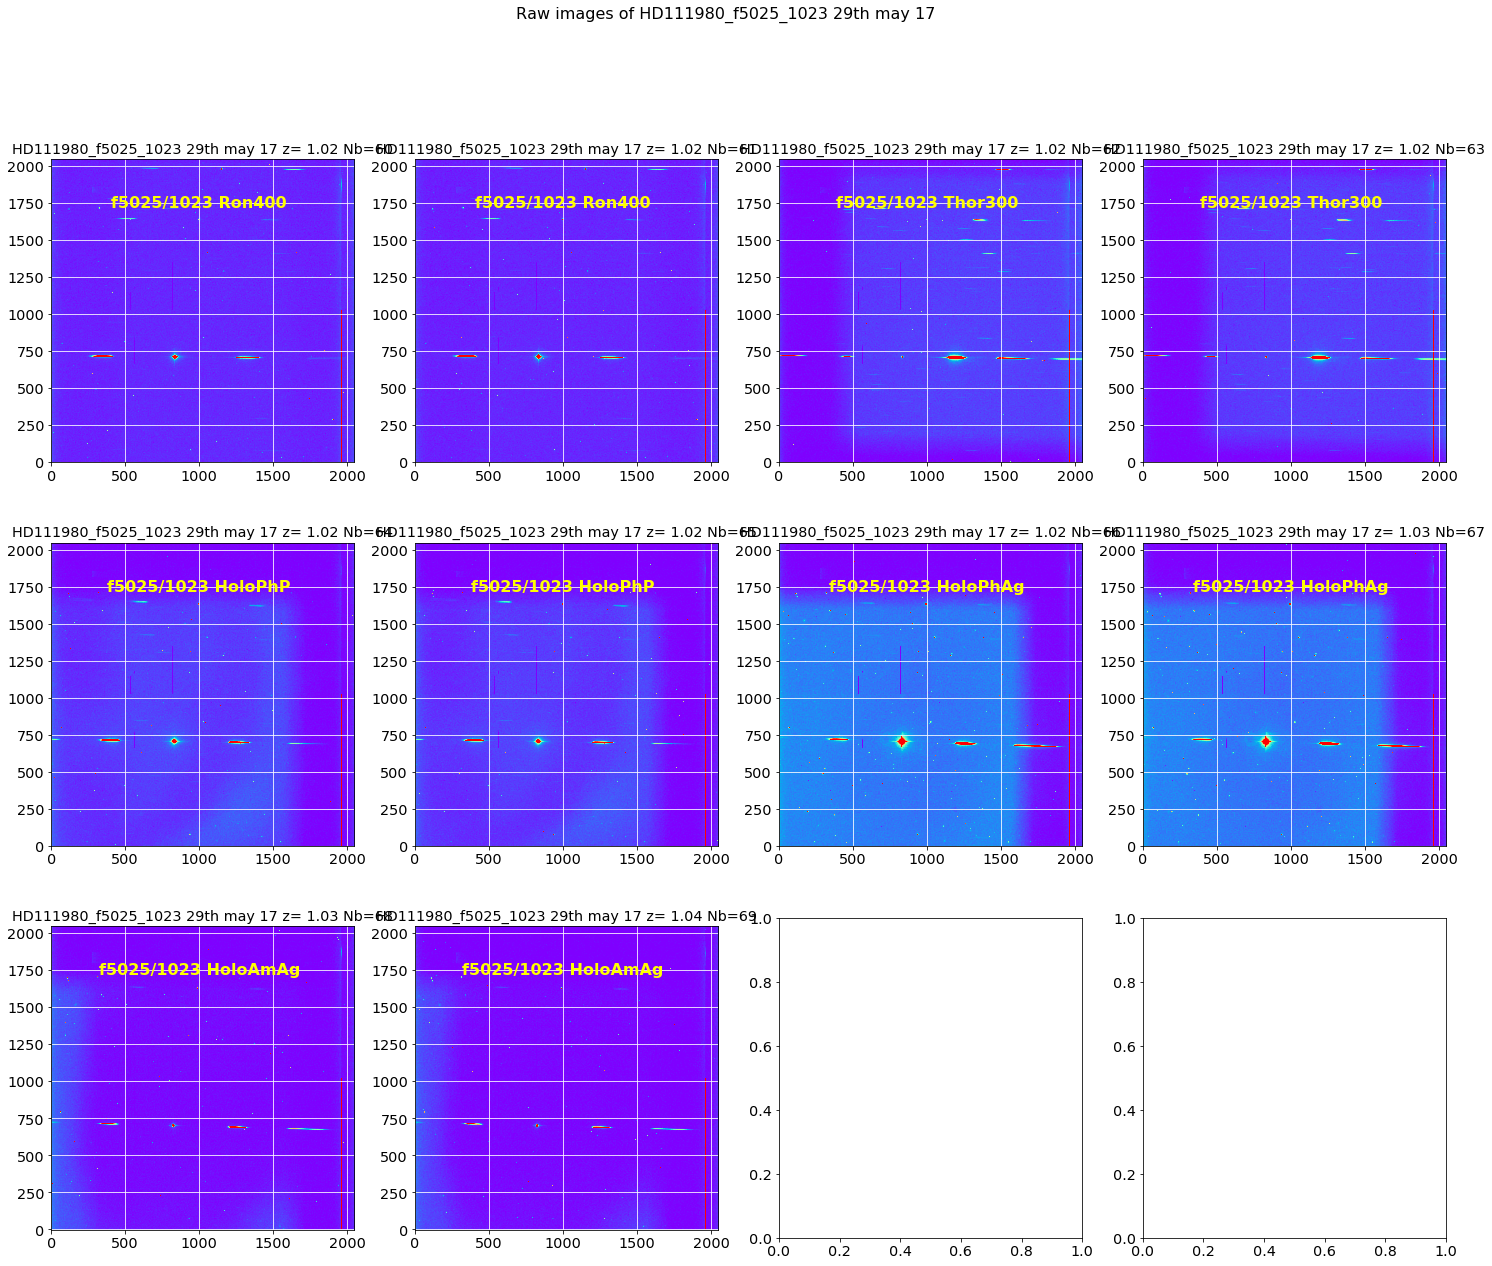

In [153]:
ShowRawImages()

### Find the star locations
----------------------------

In [154]:
%%cython
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind

def ComputeStatImages(all_images):
    """
    ComputeStatImages: 
    ==============
    """
    
    img_mean=[]
    img_median=[]
    img_std=[]
    img_sources=[]
    img_=[]
    index=0
    for image in all_images:
        mean, median, std = sigma_clipped_stats(image, sigma=10.0, iters=5)    
        print '----------------------------------------------------------------'
        print index,' mean, median, std = ',mean, median, std
        img_mean.append(mean)
        img_median.append(median)
        img_std.append(std)
        sources = daofind(image - median, fwhm=5.0, threshold=2000*std)
        print sources
        img_sources.append(sources)    
        index+=1
    return img_mean,img_median,img_std,img_sources

In [155]:
img_mean,img_median,img_std,img_sources=ComputeStatImages(all_images)

----------------------------------------------------------------
0  mean, median, std =  41.0188087722 40.0 10.4411276588


        Use DAOStarFinder instead. [astropy.utils.decorators]


 id   xcentroid     ycentroid   ...   peak       flux           mag      
--- ------------- ------------- ... ------- ------------- ---------------
  1 997.416142904 1634.59188465 ... 22161.0 1.50166500981 -0.441432653547
  2 1149.24376296 1974.95127627 ... 29123.0 2.00058658703 -0.752893381861
----------------------------------------------------------------
1  mean, median, std =  39.0596949228 38.0 10.3916939641
 id   xcentroid     ycentroid   ...   peak       flux           mag      
--- ------------- ------------- ... ------- ------------- ---------------
  1 831.017113091 708.495807925 ... 60769.0 1.97580591527  -0.73936070328
  2 833.615286022     708.22625 ... 60766.0 2.07627611858 -0.793212771787
  3 996.140703999 1634.73538392 ... 21298.0 1.43748299522  -0.39400678971
  4 1147.98613204 1975.11120561 ... 26351.0 1.80583152493 -0.641693075896
----------------------------------------------------------------
2  mean, median, std =  50.0951079999 59.0 27.4093766026
 id xcentroid yc

In [156]:
sel=1

In [157]:
thesource=img_sources[sel]
img_size=all_images[sel].shape

In [158]:
print thesource

 id   xcentroid     ycentroid   ...   peak       flux           mag      
--- ------------- ------------- ... ------- ------------- ---------------
  1 831.017113091 708.495807925 ... 60769.0 1.97580591527  -0.73936070328
  2 833.615286022     708.22625 ... 60766.0 2.07627611858 -0.793212771787
  3 996.140703999 1634.73538392 ... 21298.0 1.43748299522  -0.39400678971
  4 1147.98613204 1975.11120561 ... 26351.0 1.80583152493 -0.641693075896


In [159]:
x_star=thesource["xcentroid"]
y_star=thesource["ycentroid"]
points_set=np.array(zip(x_star,y_star))

### Default value 

- if no source were found

In [160]:
x0=x_star[0]
y0=y_star[0]

In [161]:
print 'x0,y0=',x0,y0

x0,y0= 831.017113091 708.495807925


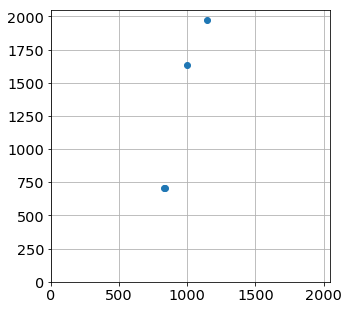

In [162]:
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

### Search the main central star
----------------------------------

In [163]:
%%cython
import numpy as np

"""
Set of routine to find the right position of the main central star
"""
def distance(v1,v2): 
    return sum([(x-y)**2 for (x,y) in zip(v1,v2)])**(0.5)

def GetDistanceSum(thepoint, points_set):
    """
    Return the distance sum of the point thepoit to the set of points points_set
    """
    dist_sum=0
    for otherpoint in points_set:
        dist= distance(thepoint,otherpoint)
        dist_sum+=dist
    return dist_sum

def GetAllDistanceSum(all_points):
    """
    Return the set of the distance sum to other point for all points
    """
    all_distances = []
    for thepoint in all_points:
        dist=GetDistanceSum(thepoint, all_points)
        all_distances.append(dist)
    all_distances=np.array(all_distances)
    return all_distances
        

def GetCentralPosition( x_star, y_star,x0,y0):
    """
    Find the position of the point which minimise the distance sum wrt other points
    """
    
    if x_star.size == 0:
        return np.array([int(y0),int(x0)])
        
    if x_star.size == 1:
        central_pos_index=0
        points_set=np.array(zip(x_star,y_star))
        return np.array([int(points_set[central_pos_index][1]),int(points_set[central_pos_index][0])])
    
    points_set=np.array(zip(x_star,y_star))
    distances_sum=GetAllDistanceSum(points_set)
    central_pos_index=np.where(distances_sum==distances_sum.min())[0][0]
    return np.array([int(points_set[central_pos_index][1]),int(points_set[central_pos_index][0])])

### Special way to find the right center of the main star

In [164]:
positions_central = []
index=0
for source in img_sources:
    x_star=source["xcentroid"]
    y_star=source["ycentroid"]
    flux=source["flux"]
    position=GetCentralPosition(x_star,y_star,x0,y0)
    print position
    positions_central.append(position)
    index+=1

[1634  997]
[708 833]
[708 831]
[708 831]
[708 831]
[708 831]
[708 831]
[708 831]
[703 823]
[702 822]


### Cut the image
------------------

In [165]:
DeltaY=200
DeltaX=600

In [166]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
import os

def ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images):
    """
    ShowCenterImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    #global dir_top_images
    
    croped_images = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,10))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        y0=int(positions_central[index][0])
        x0=int(positions_central[index][1])
       
        #image_cut=all_images[index][y0-200:y0+200,x0-200,y0+200]
        theimage=all_images[index]
        #image_cut=theimage[y0-DeltaY:y0+DeltaY,x0-DeltaX:x0+DeltaX]
        image_cut=np.copy(theimage[y0-DeltaY:y0+DeltaY,:])
        croped_images.append(image_cut)
        #aperture=CircularAperture([positions_central[index]], r=100.)
        im=axarr[iy,ix].imshow(image_cut,cmap='rainbow',vmin=0,vmax=100,origin='lower',interpolation='None')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        #aperture.plot(color='red', lw=5.)
    title='Cut Images of {}'.format(object_name)
    plt.suptitle(title,size=16) 
    
    figfilename=os.path.join(dir_top_images,'cut_images.pdf')
    plt.savefig(figfilename)   
    
    
    return croped_images

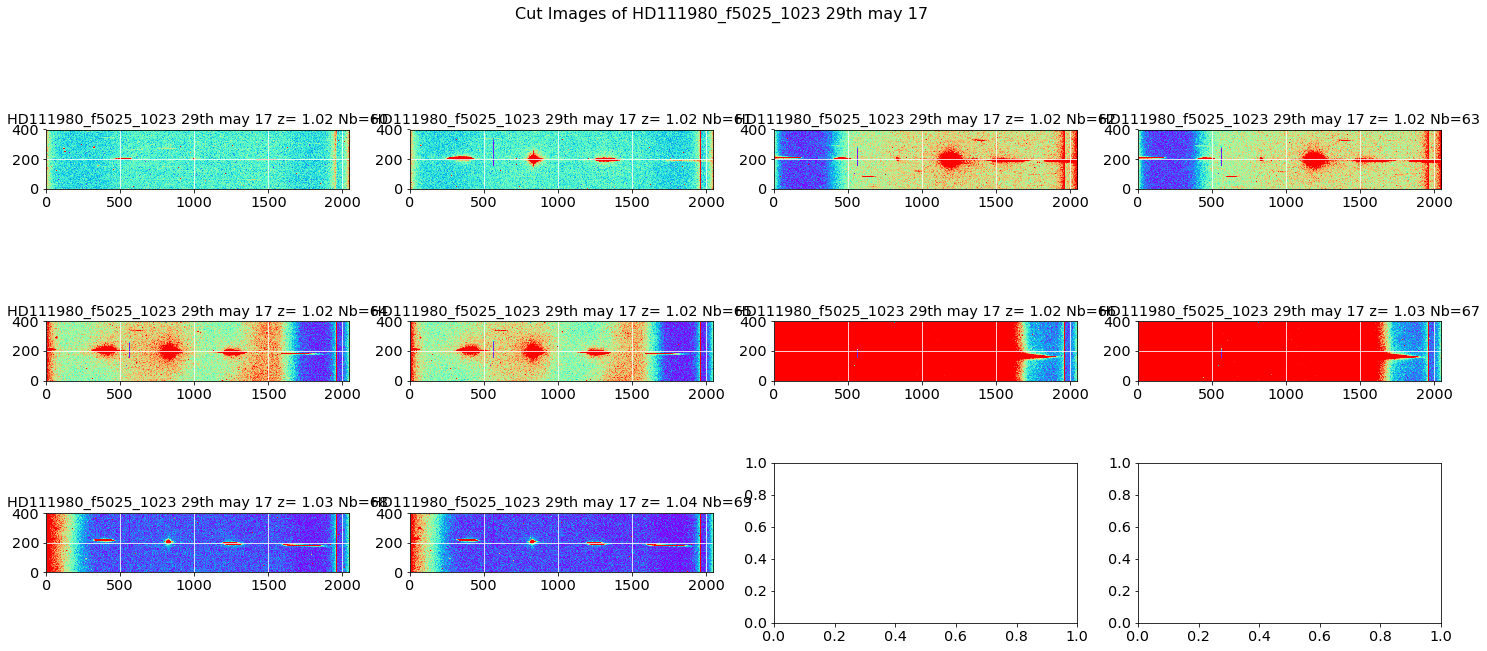

In [167]:
images_cut=ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images)

#### Example of cut image
-------------------------

In [168]:
index=0
data=np.copy(images_cut[index])
w=20
ws=80
data[:,DeltaX-ws:DeltaX+ws]=0

In [169]:
yprofile=np.sum(data,axis=1)
xprofile=np.sum(data,axis=0)

In [170]:
y_center=np.where(yprofile==yprofile.max())[0][0]
print y_center

201


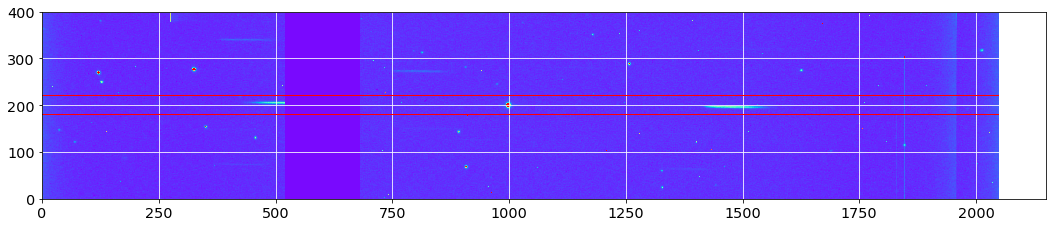

In [171]:
plt.figure(figsize=(18,18))
y0=int(positions_central[index][0])
x0=int(positions_central[index][1])
plt.imshow(data,vmin=-10,vmax=800,origin='lower',cmap='rainbow',interpolation='None')
plt.plot([0,data.shape[1]],[y_center-w,y_center-w],'r-',lw=1)
plt.plot([0,data.shape[1]],[y_center+w,y_center+w],'r-',lw=1)
plt.grid(color='white', ls='solid')
plt.show()
figfilename=os.path.join(dir_top_images,'cutimages_sample.pdf')
plt.savefig(figfilename)   

### prepare outputfilename

In [172]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    
    short_infilename=file.split("/")[3]
    print short_infilename
    short_partfilename=re.findall('^trim_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

trim_20170529_060.fits
trim_20170529_061.fits
trim_20170529_062.fits
trim_20170529_063.fits
trim_20170529_064.fits
trim_20170529_065.fits
trim_20170529_066.fits
trim_20170529_067.fits
trim_20170529_068.fits
trim_20170529_069.fits


### Save outputfilename

In [173]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

In [174]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 31 19:41 cut_fitsimages/cutimg_20170529_060.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 31 19:41 cut_fitsimages/cutimg_20170529_061.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 31 19:41 cut_fitsimages/cutimg_20170529_062.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 31 19:41 cut_fitsimages/cutimg_20170529_063.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 31 19:41 cut_fitsimages/cutimg_20170529_064.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 31 19:41 cut_fitsimages/cutimg_20170529_065.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 31 19:41 cut_fitsimages/cutimg_20170529_066.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 31 19:41 cut_fitsimages/cutimg_20170529_067.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6566400 May 31 19:41 cut_fitsimages/cutimg_20170529_068.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  6